# Pseudo-bulk dataset generator

Implement pseudo-bulk methods

**Outline**  
Basic steps to do pseudo-bulk

**1. Define groups of data to split.**  

The usual experimental design in a single-cell dataset would include populations and/or subpopulations of cells, from multiple samples.  
Each donor could be represented by 1 or multiple samples.  
The cell populations are usually (un-/semi-)supervised clusters or annotated known cell types.  
Apart from those variables, smaples might be generated by different technologies, protocols, dates..., representing batches of data which might be affected by batch effects.  

**2. Define aggregation method.**  

The `AverageExpression` method from Seurat provides multiple aggregation methods of the counts.  

**3. Define number of pseudo-bulk samples to create from each group.**  
Each group could have enough cells to recreate multiple pseudobulk samples from it. Therefore, we could extract "bootstrap" replicates from each of them. To do this, we could implement different strategies:  
- The naif one is to just split the cells in the group in sets of fixed size and then creating pseudobulks for each of those.  
- An alternative, is to fix the number of samples we want per group and divide the cells accordingly.  
- As proposed in [], we could create samples from similar cells, represented as close neighbors in the PC space. They implement an algorithm to create groups of cells per identity group that try to represent the expression space of that group.


In [1]:
load('packaging.rda', verbose=T)
set_parallel()
load('data_handling.rda', verbose=T)
load('seurat_handling.rda', verbose=T)

Loading objects:
  save_functions
  set_parallel


[1] 96

Loading objects:
  restore.factors
  save_functions
  set_parallel
  summarise.metadata
Loading objects:
  dimred.auto
  get.grouped.cells
  get.seurat.from.cells
  merge.seurat
  rename.seurat.cells
  save_functions
  set_parallel


### Pseudobulks from a Seurat object

In [2]:
get.average.expression <- function(
    object,
    group.vars = NULL,
    cluster.var = NULL,
    annotation.vars = 'all',
    slot = 'counts',
    features = NULL,
    
    
    method = 'aggregate',
    verbose = T,
    
    ...
){
    
    require(Seurat)
    warn <- if (verbose){function(x){x}}else{suppressMessages}
    
    # Define group identity
    # If cluster.var is provided, we append it to the group variables
    group.vars <- c(cluster.var, group.vars)
    
    
    # Gather group labels
    groups.df <- unique(FetchData(object = object, vars = group.vars))
    rownames(groups.df) <- apply(groups.df, 1, paste, collapse='_')
    # Gather annotation
    if (!is.null(annotation.vars)){
        
        if (annotation.vars[1]=='all'){
            annotation.vars <- colnames(object@meta.data)[!colnames(object@meta.data)%in%group.vars]
        }
        groups.df <- cbind(groups.df[,-(1:length(group.vars))],
                           summarise.metadata(
                               object@meta.data,
                               group.vars=group.vars,
                               annotation.vars=annotation.vars
                           ))
    }
    groups.df$pseudobulk.id <- rownames(groups.df)

    # If any of the group.vars have 1 unique value, we drop it for calling AverageExpression
    avg.vars <- group.vars[sapply(apply(groups.df[,group.vars, drop=F], 2, unique), length) != 1]
    
    if (length(avg.vars)==0){
        object$fake_group <- 't'
        avg.vars <- c('fake_group')
        
    }
    # Get aggregate expression
    if (method == 'average'){
        agg.exp <- warn(Seurat::AverageExpression(
            object, group.by = avg.vars,
            slot = slot, features = features,
            return.seurat = T, verbose=verbose,
            ...
        ))
    } else if (method == 'aggregate'){
        agg.exp <- warn(Seurat::AggregateExpression(
            object, group.by = avg.vars,
            slot = slot, features = features,
            return.seurat = T, verbose=verbose,
            ...
        ))
    } else {
        stop('`method` must be "aggregate" or "average"')
    }
    
    # Append groups
    # # Append correct ones
    if (ncol(agg.exp) == 1){
        agg.exp@meta.data <- groups.df
    } else {
        # # Remove groups from annotation
        agg.exp@meta.data[, colnames(agg.exp@meta.data)%in%colnames(groups.df)] <- NULL
        agg.exp@meta.data <- cbind(agg.exp@meta.data, groups.df[rownames(agg.exp@meta.data),])
    }    
    
    return(agg.exp)
}

### Generate a pseudobulk dataset

Implement:
- 1 or multiple samples per group, 
- fixed number of cells
- fixed number of samples

A general function that will map it to more specific functions

### Sampling functions

In [3]:
sample.recursively <- function(choices, n_samples=NULL, sample_size=NULL, value=T, seed=NULL, verbose=F, duplicates=T, ...){
    
    samples <- list(...)$samples

    if (all(is.null(n_samples), is.null(sample_size))){ stop('Must provide one of `n_samples` or `sample_size`') }
    
    if (is.null(samples)){
        if (verbose){message(glue::glue('Initializing for n_samples:{n_samples}, sample_size:{sample_size}'))}
        samples <- list(remaining=choices)
    }
    if (is.null(seed)) {seed <- sample(1:99999, 1)}
    
    if (is.null(sample_size)){
        sample_size <- round(length(choices)/n_samples, 0)
        if (verbose){ message(glue::glue('`sample_size` set to {sample_size}'))}
    } else if (sample_size<1){
        sample_size <- round(length(choices)*sample_size, 0)
        if (verbose){ message(glue::glue('`sample_size` set to {sample_size}'))}
    }
    
    if (is.null(n_samples)){
        n_samples <- round(length(choices)/sample_size, 0)
        if (verbose){ message(glue::glue('`n_samples` set to {n_samples}'))}
    }
    
    set.seed(seed)

    if (length(samples)-1 == n_samples){
        if (verbose){message('Finished')}
        # if (verbose){print(lapply(samples[-1], length))}
        
        if (value){
            return(samples[-1])
        }else{
            masks <- lapply(samples[-1], function(elements){choices %in% elements})
            return(masks)
                
        }
    } else {
        
        n.rem <- length(samples$remaining)
        if (verbose){message(glue::glue('Available for sample: {n.rem}'))}
        sid <- length(samples)+1
        
        if (sample_size > n.rem){
            if (verbose){message(glue::glue('It is lower than {sample_size}. Appending remaining and sampling {sample_size-n.rem}'))}
            
            extra.s <- samples$remaining
            
            new.choices <- choices[!choices%in%extra.s]
            while (length(new.choices) < sample_size-n.rem){
                new.choices <- c(new.choices, choices)
                
            }
            s <- sample(x = 1:length(new.choices), size = sample_size-n.rem, replace = F)

            # Now the remaining is the ones not chosen and the extra.s again to count it the same number of times
            samples$remaining <- c(new.choices[-s], extra.s)
            s <- c(extra.s, new.choices[s])
            samples[[sid]] <- sort(s)
                
        } else {
            new.choices <- samples$remaining
            s <- sample(x = 1:length(new.choices), size = sample_size, replace = F)
            samples[[sid]] <- sort(new.choices[s])
            samples$remaining <- new.choices[-s]
        }
        return(sample.recursively(
            choices=choices, n_samples=n_samples, sample_size=sample_size, 
            seed=seed+1, value=value, verbose=verbose, duplicates=duplicates,
            samples=samples))
    }
    
}

In [4]:
# Compute snn
sample.simspec <- function(object, ratio=1/10, ...){
    
    require(dplyr)
    require(Seurat)
    
    npcs <- min(50, ncol(object)-1)

    # message('Running scaling, variable features, PCA and neighbors')
    snn <- (
        ScaleData(object, verbose=F) %>% 
        FindVariableFeatures(verbose=F) %>% 
        RunPCA(verbose=F, npcs = npcs) %>% 
        FindNeighbors(verbose=F, dims = 1:npcs)
           )@graphs$RNA_snn
    
    sel_df <- simspec::construct_pseudocells(snn, ratio=ratio, ...)
    
    sampled.cells <- lapply(
        sort(unique(sel_df[sel_df[,2]!=-1,2])), function(ix){
        colnames(object)[sel_df[,2] == ix]
    })
    
    # return(object)
    return(sampled.cells)
    }


### general function

In [5]:
generate.pseudobulk <- function(
    object,
    group.vars = NULL,
    cluster.var = NULL,
    annotation.vars = 'all',
    slot = 'counts',
    features = NULL,
    
    samples.per.group = NULL,
    cells.per.sample = NULL,
    
    simspec.ratio = 1/100, 
    
    sel.method = 'recursive',
    agg.method = 'aggregate',
    verbose = T,
    
    ...
){
    # Append cluster
    clgroup.vars <- if(is.null(cluster.var)){group.vars}else{c(cluster.var, group.vars)}
    
    # Get groups of cells
    if (verbose){message('Grouping cells')}
    grouped.cells <- get.grouped.cells(object, clgroup.vars)
    
    if (sel.method == 'simspec'){
        if (verbose){message('Sampling cells in neighbors space (simspec)')}
        sampled.cells <- lapply(
            grouped.cells,
            function(x){
                suppressMessages(suppressWarnings(
                    sample.simspec(object[,x], ratio=simspec.ratio, ...)
                ))
            })
    } else{
        if (verbose){message('Sampling cells recursively')}
        # Sample cells for each group
        sampled.cells <- lapply(
            grouped.cells, 
            sample.recursively, 
            n_samples=samples.per.group, sample_size=cells.per.sample, value=T, verbose=F)
        
    }
    
    # name the samples
    if (verbose){message('Naming samples')}
    sampled.cells <- lapply(names(sampled.cells), function(x){
        y <- sampled.cells[[x]]
        names(y) <- paste(x, as.character(1:length(y)), sep='_rep')
        y
    })
    # unlist the masks
    sampled.cells <- do.call(sampled.cells, what='c')

    # Get pseudobulk expression
    if (verbose){message('Aggregating expression')}
        
    psbk.objects <- lapply(names(sampled.cells),
                          function(psbk.lab){
                              
                              
                              if (verbose) {
                                  i <- which(names(sampled.cells)==psbk.lab)
                                  p.i <- round(length(sampled.cells)/10*(1:10), 0)
                                  if (i%in%p.i){message(glue::glue('+ {i}/{length(sampled.cells)} ({round(i/length(sampled.cells)*100,2)}%)'))}
                              }
                              
                              # get average expression
                              suppressMessages(suppressWarnings(expr = {
                                  psbk <- get.average.expression(
                                      get.seurat.from.cells(object, cells = sampled.cells[[psbk.lab]]), 
                                      group.vars = group.vars,
                                      cluster.var=cluster.var, 
                                      slot = slot,
                                      features = features,
                                      verbose=verbose,
                                      method=agg.method, 
                                      annotation.vars=annotation.vars, ...)
                                  psbk <- rename.seurat.cells(psbk, psbk.lab)
                                  psbk$pseudobulk.id <- psbk.lab
                                  psbk$rep <- strsplit(psbk.lab, split='_rep', fixed=T)[[1]][2]
                                  psbk
                                  }))

                              
                              return(psbk)
                          })
    
    if (verbose) {message(glue::glue('Merging {length(psbk.objects)} objects'))}
    psbk <- merge.seurat(psbk.objects)
    if (verbose) {message(glue::glue('Restoring factors'))}
    psbk@meta.data <- restore.factors(x=psbk@meta.data, reference=object@meta.data)
    
    return(psbk)
}


### example

In [6]:
example <- function(
    seurat.dataname = "ifnb",
    group.vars = 'stim',
    cluster.var = 'seurat_annotations',
    sel.method='simspec', agg.method='average',
    simspec.ratio=1/100,
    samples.per.group = 6, cells.per.sample = NULL, 
    lognorm = T, scale.factor=10000,
    verbose=T, return.=F){
   
    require(Seurat)
    require(SeuratData)
    require(glue)

    
    # load dataset
    print(glue('First we load the object {seurat.dataname}'))
    object <- LoadData(seurat.dataname)
    print(head(object@meta.data))
    
    
    psbk <- generate.pseudobulk(object, 
                                group.vars = group.vars, cluster.var=cluster.var, 
                                simspec.ratio=simspec.ratio,
                                sel.method=sel.method,
                                agg.method=agg.method,
                                samples.per.group = samples.per.group, 
                                cells.per.sample = cells.per.sample, 
                                verbose=verbose)

    psbk <- dimred.auto(psbk, scale.factor = scale.factor, lognorm = lognorm, plot.vars=c(cluster.var, group.vars))
    
    if (return.){return(list(data=object, pseudobulk=psbk))}
    return()
}

In [7]:
cat(save_functions('pseudobulk_generation'))

Loading required package: glue



dimred.auto <- function (object, lognorm = T, scale.factor = 10000, plot.vars = NULL, 
    base.size = 5, umap = T, tsne = T, pca = T) 
{
    require(Seurat)
    suppressMessages(suppressWarnings(expr = {
        if (lognorm) {
            object <- NormalizeData(object, scale.factor = scale.factor)
        }
        object <- ScaleData(object)
        object <- FindVariableFeatures(object)
        npcs <- min(ncol(object) - 1, 50)
        object <- RunPCA(object, npcs = npcs)
        options(repr.plot.height = 8, repr.plot.width = 16)
    }))
    if (!is.null(plot.vars) & pca) {
        pca.plots <- NULL
        for (pvar in plot.vars) {
            p <- LabelClusters(DimPlot(object, pt.size = 4, reduction = "pca", 
                group.by = pvar, ), id = pvar)
            pca.plots <- if (is.null(pca.plots)) {
                p
            }
            else {
                pca.plots + p
            }
        }
        plot(pca.plots)
    }
    if (umap) {
        object <- RunUMA

Loading required package: Seurat

The legacy packages maptools, rgdal, and rgeos, underpinning the sp package,
which was just loaded, will retire in October 2023.
Please refer to R-spatial evolution reports for details, especially
https://r-spatial.org/r/2023/05/15/evolution4.html.
It may be desirable to make the sf package available;
package maintainers should consider adding sf to Suggests:.
The sp package is now running under evolution status 2
     (status 2 uses the sf package in place of rgdal)

Attaching SeuratObject

Loading required package: SeuratData

── Installed datasets ───────────────────────────────────── SeuratData v0.2.2 ──

✔ hcabm40k 3.0.0                        ✔ pbmc3k   3.1.4
✔ ifnb     3.1.0                        


────────────────────────────────────── Key ─────────────────────────────────────

✔ Dataset loaded successfully
❯ Dataset built with a newer version of Seurat than installed
❓ Unknown version of Seurat installed




First we load the object ifnb
                  orig.ident nCount_RNA nFeature_RNA stim seurat_annotations
AAACATACATTTCC.1 IMMUNE_CTRL       3017          877 CTRL          CD14 Mono
AAACATACCAGAAA.1 IMMUNE_CTRL       2481          713 CTRL          CD14 Mono
AAACATACCTCGCT.1 IMMUNE_CTRL       3420          850 CTRL          CD14 Mono
AAACATACCTGGTA.1 IMMUNE_CTRL       3156         1109 CTRL                pDC
AAACATACGATGAA.1 IMMUNE_CTRL       1868          634 CTRL       CD4 Memory T
AAACATACGGCATT.1 IMMUNE_CTRL       1581          557 CTRL          CD14 Mono


Warning message:
“The default method for RunUMAP has changed from calling Python UMAP via reticulate to the R-native UWOT using the cosine metric
To use Python UMAP via reticulate, set umap.method to 'umap-learn' and metric to 'correlation'
This message will be shown once per session”


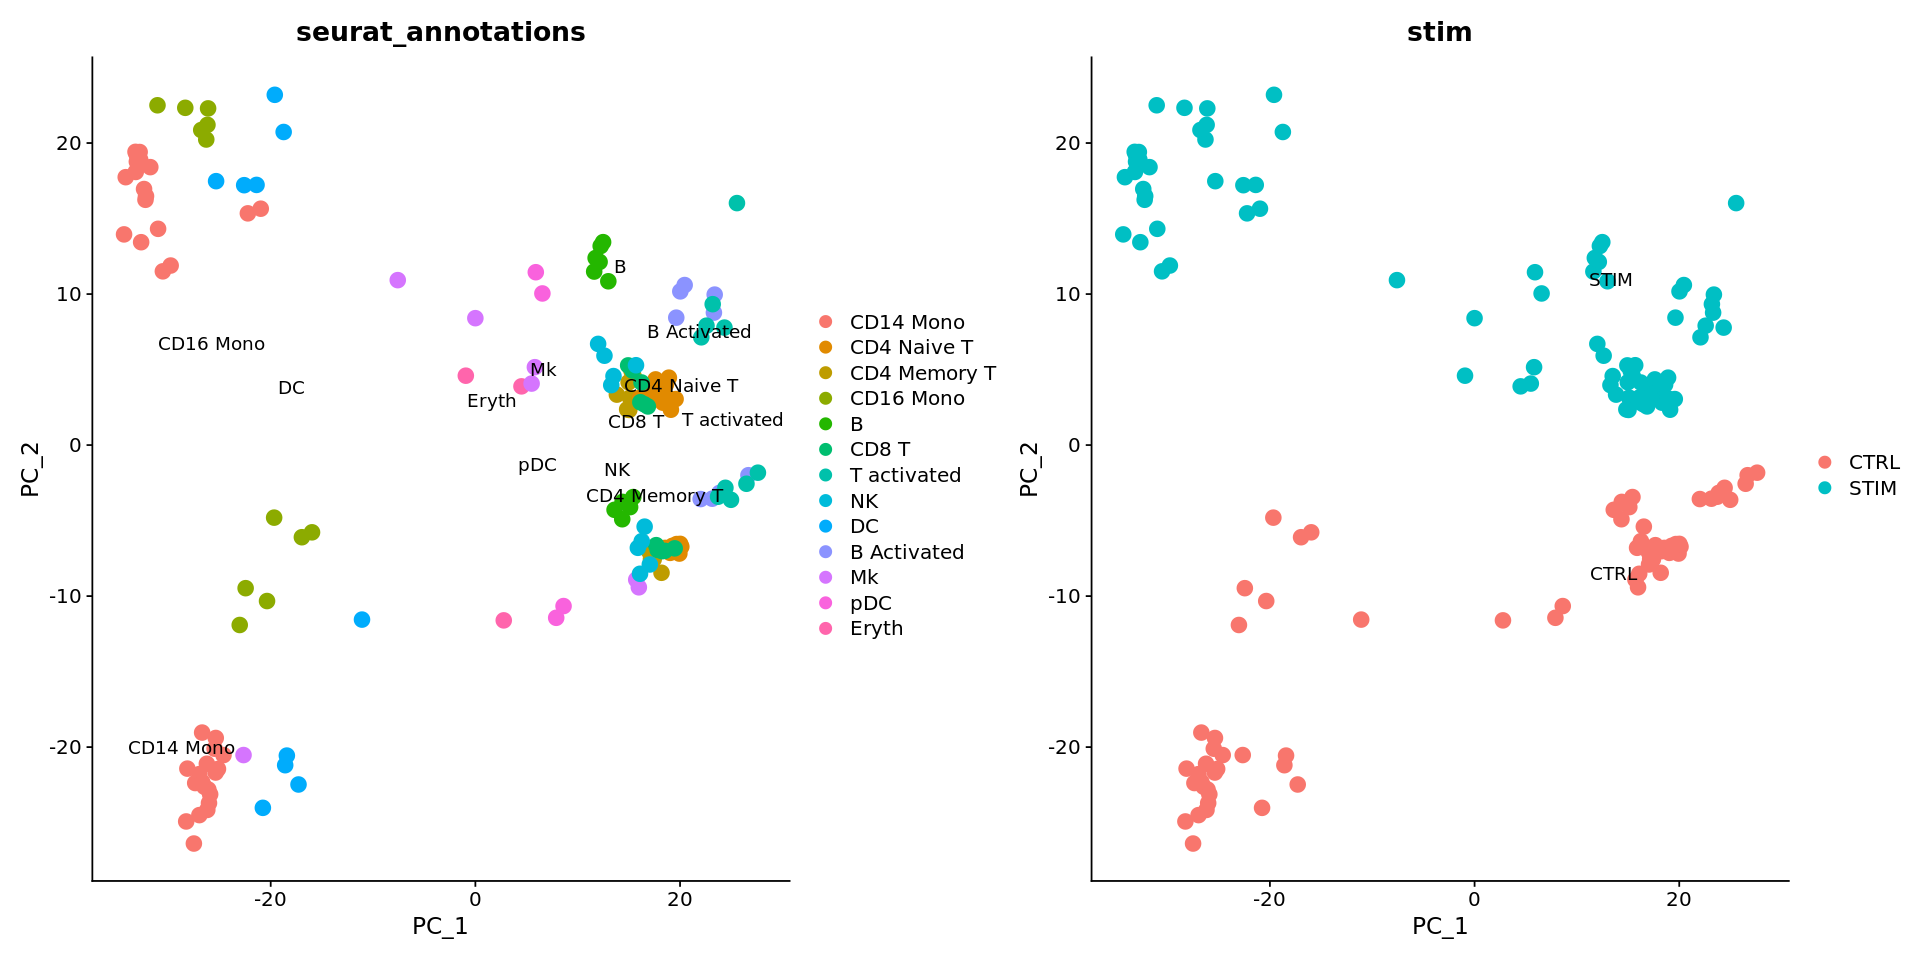

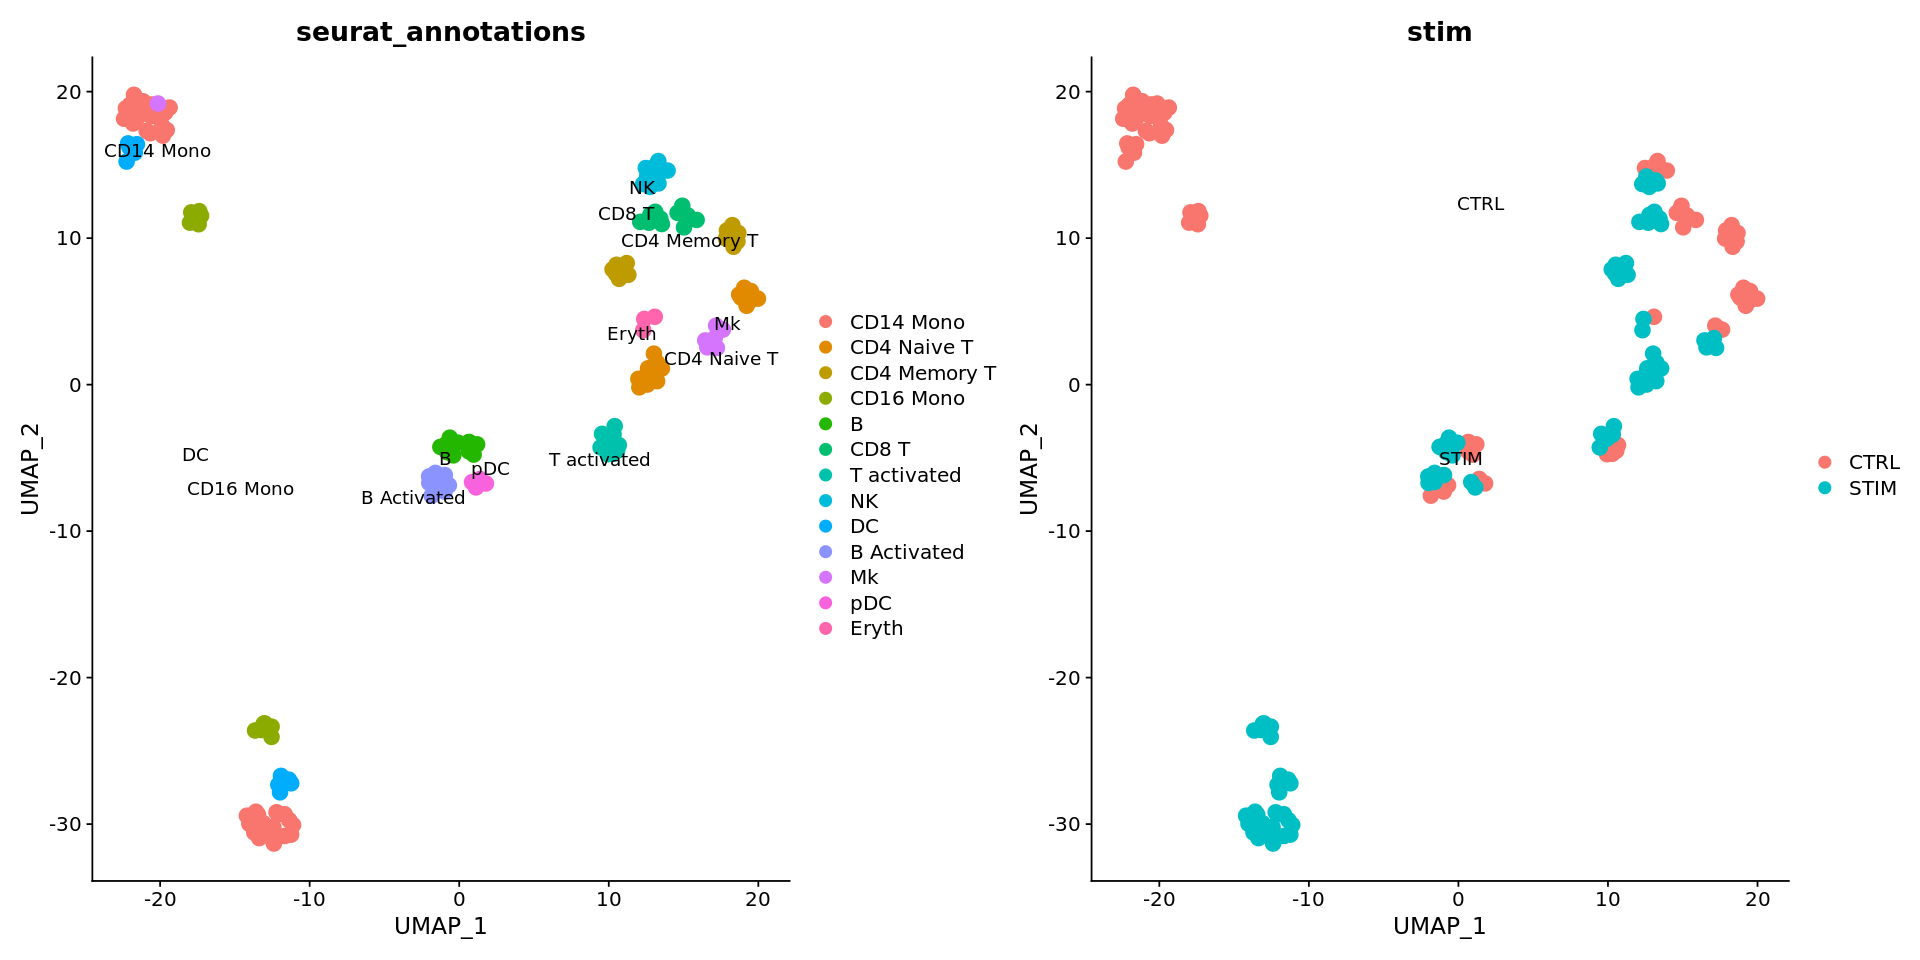

NULL

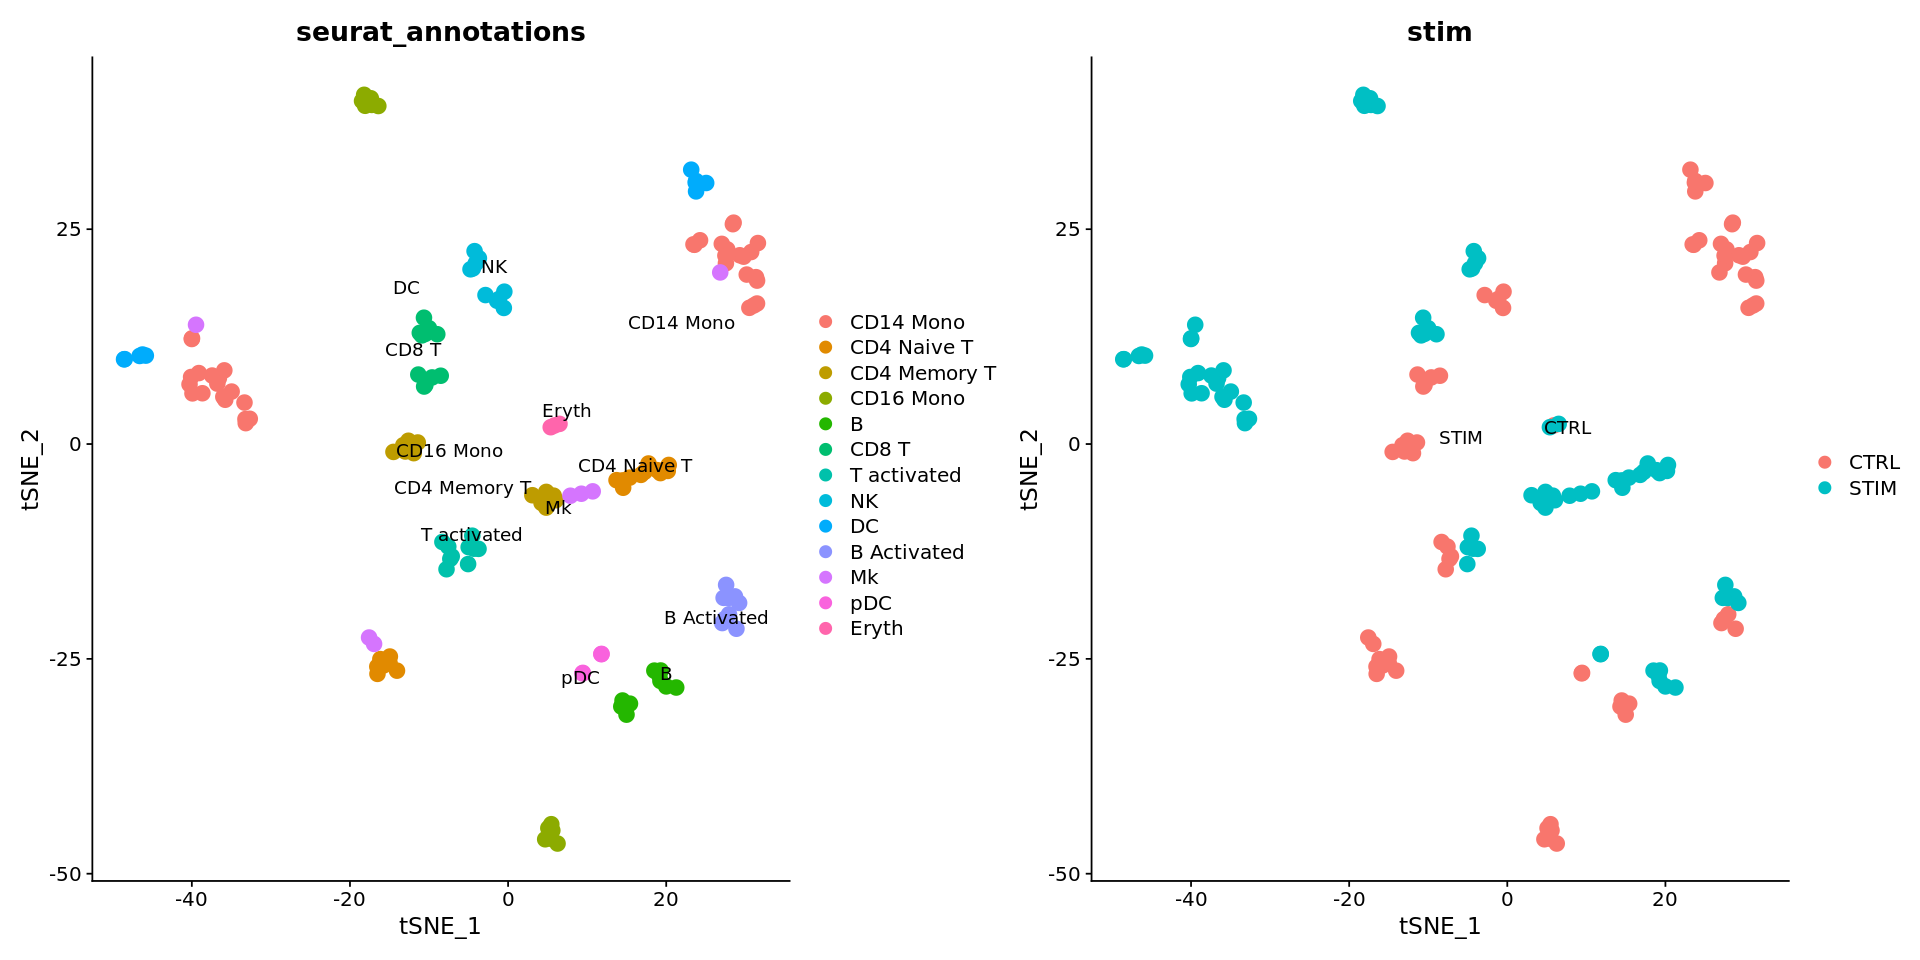

In [8]:
example(sel.method = 'simspec', lognorm=T, verbose=F)

First we load the object ifnb
                  orig.ident nCount_RNA nFeature_RNA stim seurat_annotations
AAACATACATTTCC.1 IMMUNE_CTRL       3017          877 CTRL          CD14 Mono
AAACATACCAGAAA.1 IMMUNE_CTRL       2481          713 CTRL          CD14 Mono
AAACATACCTCGCT.1 IMMUNE_CTRL       3420          850 CTRL          CD14 Mono
AAACATACCTGGTA.1 IMMUNE_CTRL       3156         1109 CTRL                pDC
AAACATACGATGAA.1 IMMUNE_CTRL       1868          634 CTRL       CD4 Memory T
AAACATACGGCATT.1 IMMUNE_CTRL       1581          557 CTRL          CD14 Mono


Warning message:
“ggrepel: 5 unlabeled data points (too many overlaps). Consider increasing max.overlaps”


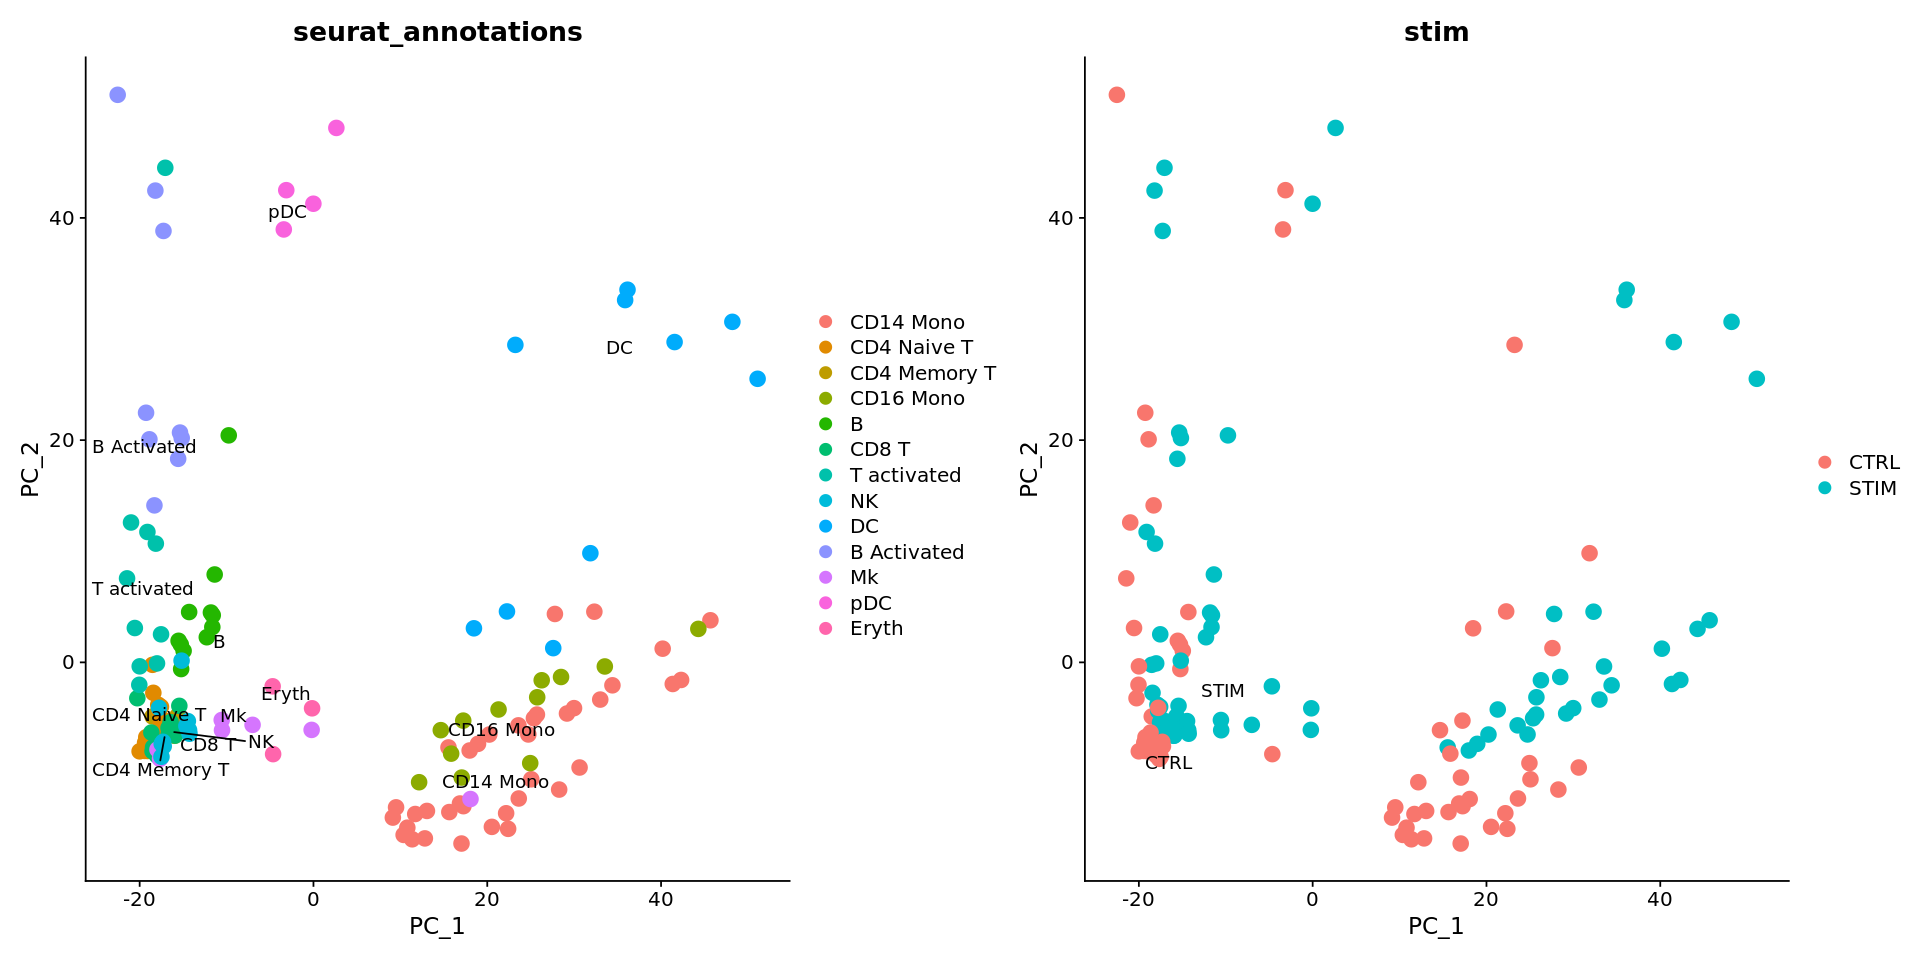

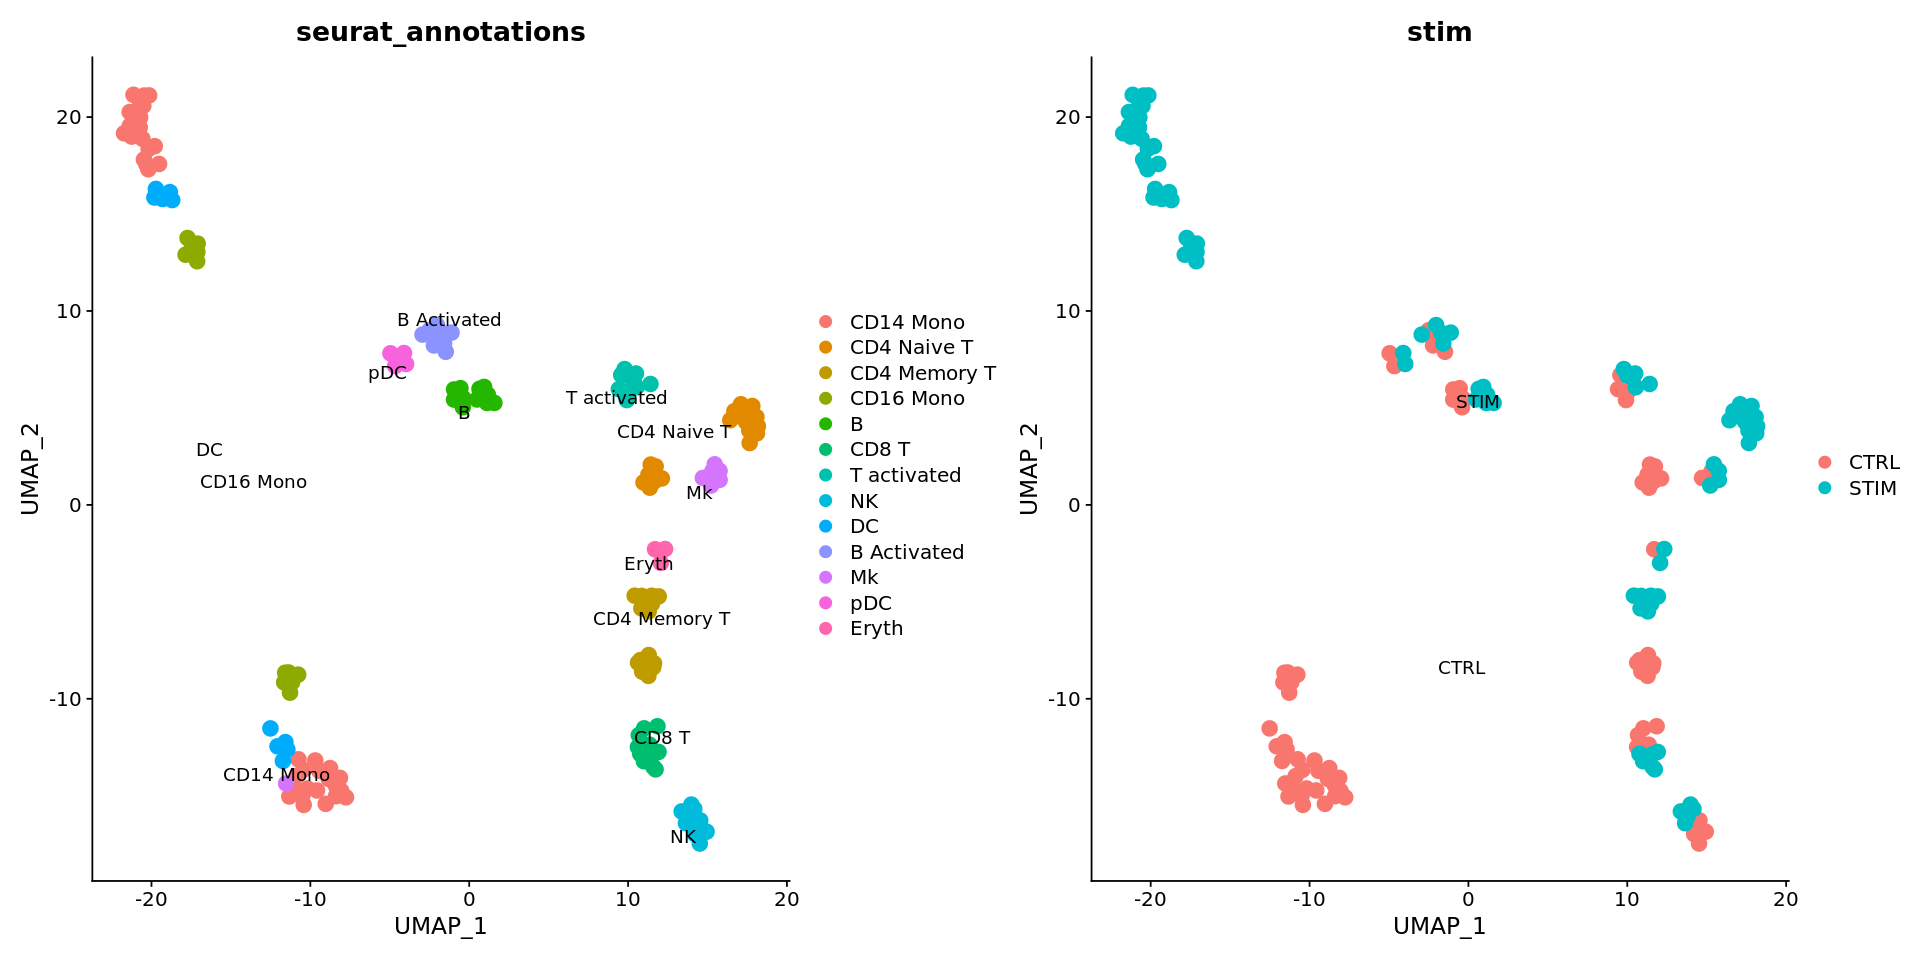

NULL

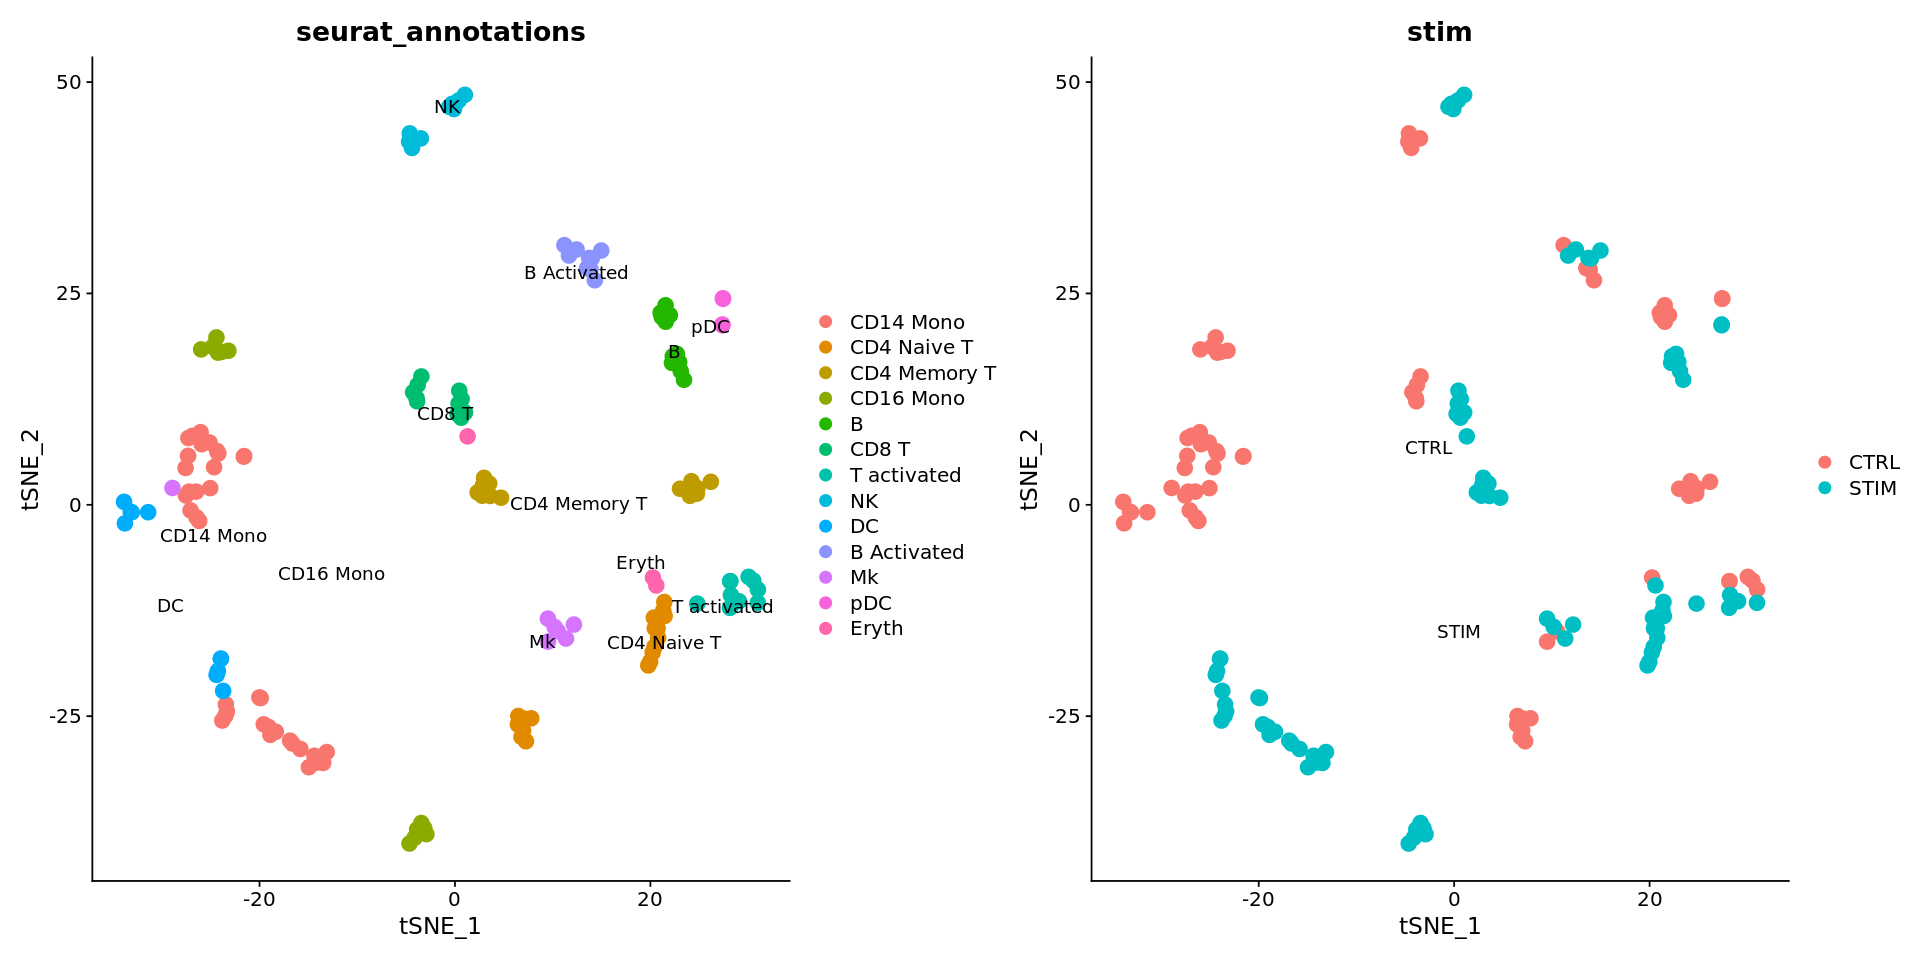

In [9]:
example(sel.method = 'simspec', lognorm=F, verbose=F)

In [ ]:
example(sel.method = 'recursive', lognorm=T, verbose=F)

In [ ]:
example(sel.method = 'recursive', lognorm=F, verbose=F)